In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(123)
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import keras



### Generator

In [2]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [3]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(5232, 256, 256, 3)
(5232, 2)
(624, 256, 256, 3)
(624, 2)


In [4]:
train_generator.class_indices


{'NORMAL': 0, 'PNEUMONIA': 1}

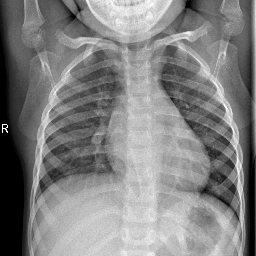

In [5]:
array_to_img(train_images[132])


In [6]:
train_labels[132]


array([1., 0.], dtype=float32)

### Fixing the labels

In [7]:
# fix the labels for the images so that normal=0 and pneumonia=1
y_model = train_labels.T[[1]]
y_test = test_labels.T[[1]]

In [8]:
y_model, y_model.shape

(array([[1., 1., 0., ..., 0., 1., 1.]], dtype=float32), (1, 5232))

In [9]:
# counts for each class
print('Train Class Counts:', np.unique(y_model, return_counts=True))
print('Test Class Counts:', np.unique(y_test, return_counts=True))

Train Class Counts: (array([0., 1.], dtype=float32), array([1349, 3883]))
Test Class Counts: (array([0., 1.], dtype=float32), array([234, 390]))


In [10]:
y_model = y_model.T
y_test = y_test.T

In [11]:
test_images.shape

(624, 256, 256, 3)

### Reshape and standardize images

In [12]:
# reshape the images
train_img_unrow = train_images.reshape(5232, -1)
test_img_unrow = test_images.reshape(624, -1)

In [13]:
test_img_unrow.shape

(624, 196608)

In [14]:
train_img_unrow, train_img_unrow

(array([[ 32.,  32.,  32., ...,   0.,   0.,   0.],
        [ 12.,  12.,  12., ...,  11.,  11.,  11.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [103., 103., 103., ...,   0.,   0.,   0.],
        [  1.,   1.,   1., ...,  22.,  22.,  22.],
        [ 22.,  22.,  22., ...,  20.,  20.,  20.]], dtype=float32),
 array([[ 32.,  32.,  32., ...,   0.,   0.,   0.],
        [ 12.,  12.,  12., ...,  11.,  11.,  11.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [103., 103., 103., ...,   0.,   0.,   0.],
        [  1.,   1.,   1., ...,  22.,  22.,  22.],
        [ 22.,  22.,  22., ...,  20.,  20.,  20.]], dtype=float32))

In [15]:
# standardize data
X_model = train_img_unrow/255
X_test = test_img_unrow/255

In [16]:
X_model.shape, X_test.shape

((5232, 196608), (624, 196608))

### Model building:

#### Model # 1

In [17]:
# split model set into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=123)

In [18]:
# function for visualizing loss and accuracy across epochs for training and validation set
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

In [19]:
model_1 = Sequential()
model_1.add(layers.Dense(128, activation='tanh', input_shape=(196608,)))
model_1.add(layers.Dense(64, activation='tanh'))
model_1.add(layers.Dense(32, activation='tanh'))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy', keras.metrics.Recall()])


In [21]:
results_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/10
66/66 [==============================] - 12s 186ms/step - loss: 0.6797 - accuracy: 0.6648 - recall: 0.8480 - val_loss: 0.5543 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 2/10
66/66 [==============================] - 7s 106ms/step - loss: 0.5365 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.5576 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 3/10
66/66 [==============================] - 7s 108ms/step - loss: 0.5371 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.4729 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 4/10
66/66 [==============================] - 8s 116ms/step - loss: 0.4840 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.5154 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 5/10
66/66 [==============================] - 10s 158ms/step - loss: 0.4634 - accuracy: 0.7668 - recall: 0.9936 - val_loss: 0.4634 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 6/10
66/66 [==============================] - 10s 154ms/step - loss: 0.4197 - accuracy: 0.80

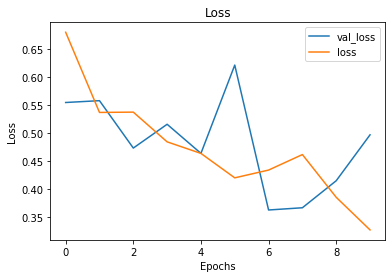

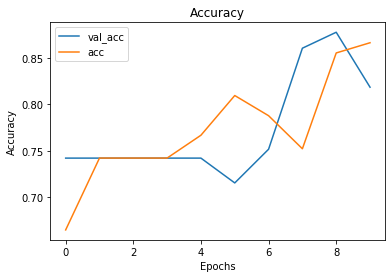

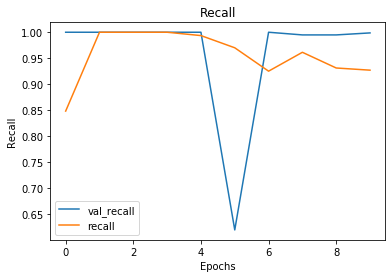

In [22]:
# change in loss and accuracy for training and validation set per epoch
visualize_training_results(results_1)


In [23]:
# evaluate training and test sets
results_train = model_1.evaluate(X_train, y_train)
results_test = model_1.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 1s 34ms/step - loss: 0.9568 - accuracy: 0.6651 - recall: 1.0000
[0.5077478885650635, 0.8112305998802185, 0.9987121820449829] [0.9567636251449585, 0.6650640964508057, 1.0]


#### Model #2

In [24]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [25]:
train_labels.shape

(5232, 2)

In [26]:
test_labels.shape

(624, 2)

In [27]:
train_labels = np.reshape(train_labels[:,1], (5232,1))


In [28]:
test_labels = np.reshape(test_labels[:,1], (624,1))

In [29]:
train_labels.shape, test_labels.shape

((5232, 1), (624, 1))

In [30]:
y_train.shape

(4185, 1)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

In [32]:
#y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
#y_val = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [33]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['accuracy', 'Recall'])

In [34]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                      workers = -1)

Epoch 1/10
84/84 [==============================] - 233s 3s/step - loss: 0.3085 - accuracy: 0.8614 - recall: 0.9368 - val_loss: 0.1110 - val_accuracy: 0.9580 - val_recall: 0.9885
Epoch 2/10
84/84 [==============================] - 173s 2s/step - loss: 0.1034 - accuracy: 0.9591 - recall: 0.9736 - val_loss: 0.0991 - val_accuracy: 0.9666 - val_recall: 0.9846
Epoch 3/10
84/84 [==============================] - 169s 2s/step - loss: 0.0825 - accuracy: 0.9680 - recall: 0.9778 - val_loss: 0.0863 - val_accuracy: 0.9713 - val_recall: 0.9833
Epoch 4/10
84/84 [==============================] - 172s 2s/step - loss: 0.0657 - accuracy: 0.9785 - recall: 0.9852 - val_loss: 0.1085 - val_accuracy: 0.9647 - val_recall: 0.9603
Epoch 5/10
84/84 [==============================] - 180s 2s/step - loss: 0.0474 - accuracy: 0.9838 - recall: 0.9878 - val_loss: 0.0871 - val_accuracy: 0.9675 - val_recall: 0.9872
Epoch 6/10
84/84 [==============================] - 216s 3s/step - loss: 0.0356 - accuracy: 0.9871 - reca

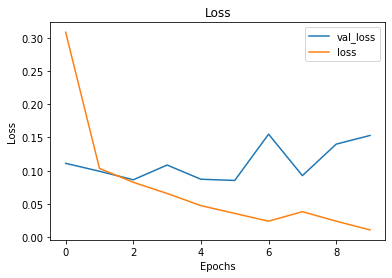

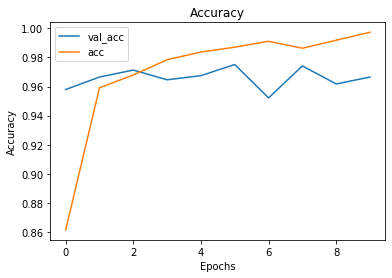

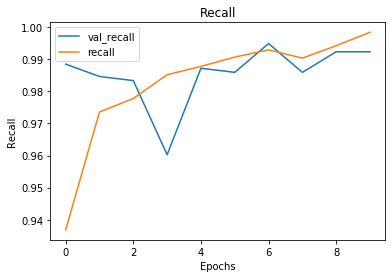

In [35]:
visualize_training_results(cnn1)


In [36]:
## Test set:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4185, 256, 256, 3), (4185, 1), (624, 196608), (624, 1))

In [37]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

20/20 [==============================] - 7s 340ms/step - loss: 5.2415 - accuracy: 0.5994 - recall: 0.8615
[0.013476468622684479, 0.9954599738121033, 1.0] [5.241526126861572, 0.5993589758872986, 0.8615384697914124]


It seems like our model is doing well in the training set but not as well in the test set. I can see overfitting I wil l try to add more complexitiy  

In [38]:
# How to improve our model?
# How to deal with class imbalance ? (data augmentation vs downsample/upsample)

## baseline model - during preprocessing before resampling
## DROP OUT, lasso-ridge, augment images (throw away)

### 2nd CNN Model:

In [39]:
cnn_2 = models.Sequential()
cnn_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Conv2D(64, (3, 3), activation='selu', input_shape=(256, 256,  3)))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Flatten())
cnn_2.add(layers.Dense(32, activation='relu'))
cnn_2.add(layers.Dense(1, activation='sigmoid'))

cnn_2.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['accuracy', 'Recall'])

In [40]:
cnn2 = cnn_2.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                      workers = -1)

Epoch 1/10
84/84 [==============================] - 201s 2s/step - loss: 0.3124 - accuracy: 0.8519 - recall: 0.9227 - val_loss: 0.1276 - val_accuracy: 0.9570 - val_recall: 0.9859
Epoch 2/10
84/84 [==============================] - 198s 2s/step - loss: 0.1092 - accuracy: 0.9594 - recall: 0.9733 - val_loss: 0.0879 - val_accuracy: 0.9694 - val_recall: 0.9833
Epoch 3/10
84/84 [==============================] - 200s 2s/step - loss: 0.1402 - accuracy: 0.9460 - recall: 0.9646 - val_loss: 0.0927 - val_accuracy: 0.9675 - val_recall: 0.9769
Epoch 4/10
84/84 [==============================] - 203s 2s/step - loss: 0.0776 - accuracy: 0.9699 - recall: 0.9803 - val_loss: 0.1396 - val_accuracy: 0.9570 - val_recall: 0.9487
Epoch 5/10
84/84 [==============================] - 209s 2s/step - loss: 0.0688 - accuracy: 0.9740 - recall: 0.9829 - val_loss: 0.0928 - val_accuracy: 0.9675 - val_recall: 0.9744
Epoch 6/10
84/84 [==============================] - 237s 3s/step - loss: 0.0589 - accuracy: 0.9785 - reca

In [41]:
results_train = cnn_2.evaluate(X_train, y_train)
results_test = cnn_2.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

20/20 [==============================] - 9s 440ms/step - loss: 4.4025 - accuracy: 0.5978 - recall: 0.8282
[0.01661490462720394, 0.9949820637702942, 0.9983886480331421] [4.402534484863281, 0.5977563858032227, 0.8282051086425781]


In [42]:
cnn2.history

{'loss': [0.31237325072288513,
  0.10924725979566574,
  0.14016737043857574,
  0.07755190134048462,
  0.06876557320356369,
  0.05887214466929436,
  0.05349935591220856,
  0.05133765935897827,
  0.031190820038318634,
  0.030013596639037132],
 'accuracy': [0.8518518805503845,
  0.959378719329834,
  0.9459975957870483,
  0.9698925018310547,
  0.9739546179771423,
  0.9784946441650391,
  0.9811230301856995,
  0.9801672697067261,
  0.9894862771034241,
  0.9892473220825195],
 'recall': [0.9226555228233337,
  0.9732517004013062,
  0.9645504355430603,
  0.9803416132926941,
  0.9829197525978088,
  0.9845311045646667,
  0.9854978919029236,
  0.9871092438697815,
  0.9919432997703552,
  0.9932323694229126],
 'val_loss': [0.12760815024375916,
  0.08792846649885178,
  0.09272534400224686,
  0.1395934522151947,
  0.09278327226638794,
  0.08432161808013916,
  0.1914723962545395,
  0.08545460551977158,
  0.08202410489320755,
  0.09830896556377411],
 'val_accuracy': [0.9570200443267822,
  0.9694364666938

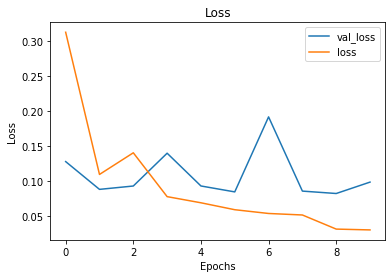

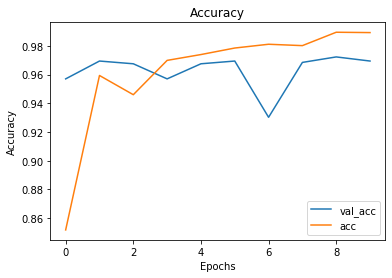

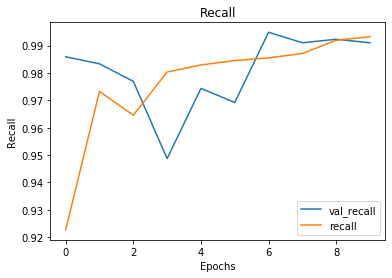

In [43]:
visualize_training_results(cnn2)


### Model #3:

In [50]:
# model fit
cnn_3 = models.Sequential()
cnn_3.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(256, 256, 3)))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Conv2D(64, 3, activation = 'relu'))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Conv2D(128, 3, activation = 'relu'))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Flatten())
cnn_3.add(layers.Dense(512, activation = 'relu'))
cnn_3.add(layers.Dense(1, activation='sigmoid'))

In [51]:
cnn_3.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['accuracy', 'Recall'])

In [52]:
cnn3 = cnn_3.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                      workers = -1)

Epoch 1/10
84/84 [==============================] - 198s 2s/step - loss: 0.3950 - accuracy: 0.8894 - recall: 0.9339 - val_loss: 0.1048 - val_accuracy: 0.9675 - val_recall: 0.9872
Epoch 2/10
84/84 [==============================] - 187s 2s/step - loss: 0.0982 - accuracy: 0.9618 - recall: 0.9736 - val_loss: 0.1179 - val_accuracy: 0.9580 - val_recall: 0.9500
Epoch 3/10
84/84 [==============================] - 186s 2s/step - loss: 0.0707 - accuracy: 0.9720 - recall: 0.9791 - val_loss: 0.0901 - val_accuracy: 0.9685 - val_recall: 0.9782
Epoch 4/10
84/84 [==============================] - 192s 2s/step - loss: 0.0476 - accuracy: 0.9814 - recall: 0.9868 - val_loss: 0.0722 - val_accuracy: 0.9742 - val_recall: 0.9782
Epoch 5/10
84/84 [==============================] - 214s 3s/step - loss: 0.0330 - accuracy: 0.9866 - recall: 0.9897 - val_loss: 0.0736 - val_accuracy: 0.9752 - val_recall: 0.9897
Epoch 6/10
84/84 [==============================] - 202s 2s/step - loss: 0.0234 - accuracy: 0.9921 - reca

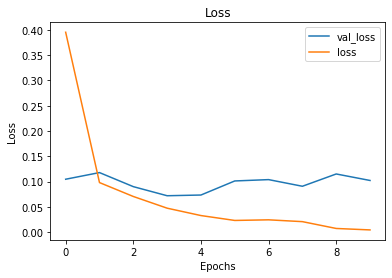

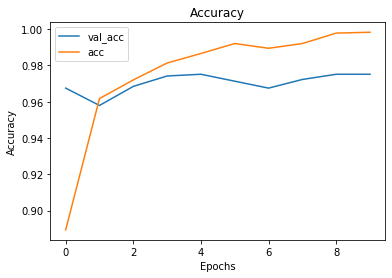

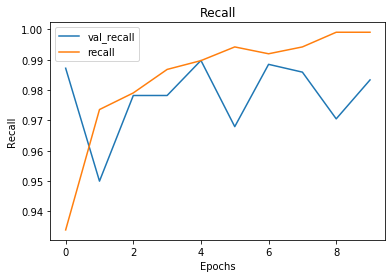

In [53]:
visualize_training_results(cnn3)


In [54]:
results_train = cnn_3.evaluate(X_train, y_train)
results_test = cnn_3.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

20/20 [==============================] - 8s 389ms/step - loss: 7.1114 - accuracy: 0.5865 - recall: 0.8026
[0.0019165045814588666, 1.0, 1.0] [7.111440658569336, 0.5865384340286255, 0.8025640845298767]


### Model 4: Adding Data Augmentation

In [45]:
train_generator_aug = ImageDataGenerator(rescale = 1./255,
                                         brightness_range = [0.8, 1.2],
                                         horizontal_flip=True)

train_generator_aug = train_generator_aug.flow_from_directory(train_data_dir,
                                              target_size = (256,256), 
                                              class_mode='binary')
train_images, train_labels = next(train_generator_aug)
test_images, test_labels = next(test_generator)

Found 5232 images belonging to 2 classes.


In [46]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [47]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', 'Recall'])

In [48]:
history = model.fit(X_train,
                    y_train,
                    epochs=10, 
                    validation_data = (X_val, y_val),
                    workers = -1,  
                    verbose = 2
                   )

NameError: name 'model_aug' is not defined